In [1]:
import os
import json
import glob
import pandas as pd
import numpy as np
from pymoo.indicators.hv import HV

def cal_hv(front, ref_point):
    with np.errstate(divide='ignore', invalid='ignore'):
        scaled_front = np.divide(front, ref_point, out=np.zeros_like(front), where=ref_point!=0)
    scaled_ref_point = np.ones_like(ref_point)
    hv_indicator = HV(ref_point=scaled_ref_point)
    return hv_indicator(scaled_front)

# Settings
base_path = "F:/setup files/downloads/Result2/"
nadir_csv_path = os.path.join(base_path, "nadir_points.csv")

# Load the nadir points CSV
nadir_df = pd.read_csv(nadir_csv_path)

# Define generation range from 0 to 150
generation_steps = range(0, 151)  # 0 to 150

# Choose problem types or adapt as needed
problem_types = [200, 400, 800]

for prob_type in problem_types:
    # Adjust file pattern as needed based on naming convention
    file_pattern = os.path.join(base_path, f"*_{prob_type//100}_*_0.json")
    files = glob.glob(file_pattern)
    
    if not files:
        print(f"No files found for problem type {prob_type}.")
        continue

    # Dictionary to store HV trends: {algorithm: {generation: [HV values across files]}}
    hv_trends = {}

    for file_path in files:
        file_name = os.path.basename(file_path)

        # Retrieve corresponding nadir row
        nadir_row = nadir_df[nadir_df['file'] == file_name]
        if nadir_row.empty:
            print(f"Nadir info not found for {file_name}. Skipping.")
            continue
        nadir_row = nadir_row.iloc[0]

        # Extract nadir point for scaling
        obj_columns = sorted(
            [col for col in nadir_df.columns if col.startswith("obj_") and col.endswith("_nadir")],
            key=lambda x: int(x.split('_')[1])
        )
        nadir_point = np.array([nadir_row[col] for col in obj_columns])

        # Load JSON data from file
        with open(file_path, 'r') as f:
            data = json.load(f)

        # Iterate over algorithms in the JSON data
        for algorithm in data:
            # Initialize hv_trends for algorithm if not present
            if algorithm not in hv_trends:
                hv_trends[algorithm] = {gen: [] for gen in generation_steps}

            # Loop through generations 0 to 150
            for gen in generation_steps:
                gen_key = str(gen)
                if gen_key not in data[algorithm]:
                    # Skip if generation data is missing
                    continue

                solutions = data[algorithm][gen_key]
                solutions_np = np.array(solutions)

                if solutions_np.size == 0:
                    continue

                try:
                    hv_value = cal_hv(solutions_np, nadir_point)
                except Exception as e:
                    print(f"Error computing HV for {algorithm} at generation {gen} in {file_name}: {e}")
                    continue

                hv_trends[algorithm][gen].append(hv_value)

    # Compute average HV per generation across files for each algorithm
    avg_hv_trends = {}
    for algorithm, gen_dict in hv_trends.items():
        avg_hv_trends[algorithm] = {
            gen: np.mean(hv_list) if hv_list else np.nan 
            for gen, hv_list in gen_dict.items()
        }

    # Convert the average HV trends into a DataFrame and save to CSV
    df_avg_hv = pd.DataFrame(avg_hv_trends)
    csv_filename = os.path.join(base_path, f"Avg_HV_Trends_Type_{prob_type//100}.csv")
    df_avg_hv.to_csv(csv_filename, index_label='Generation')
    print(f"Average HV trends saved to {csv_filename}")

    # If you only want to process the first problem type, uncomment the next line:
    # break

Average HV trends saved to F:/setup files/downloads/Result2/Avg_HV_Trends_Type_2.csv
Average HV trends saved to F:/setup files/downloads/Result2/Avg_HV_Trends_Type_4.csv
Average HV trends saved to F:/setup files/downloads/Result2/Avg_HV_Trends_Type_8.csv


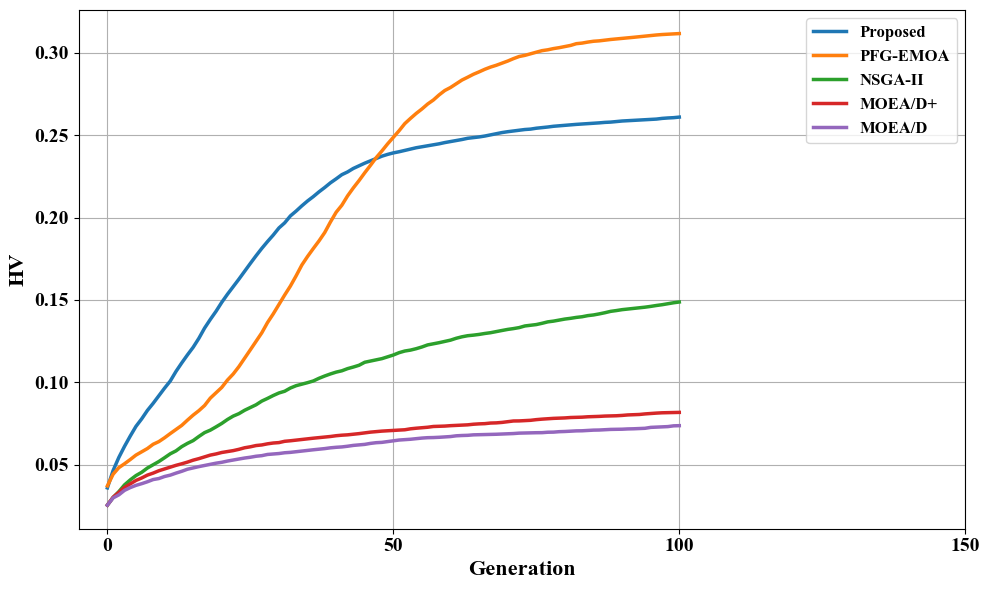

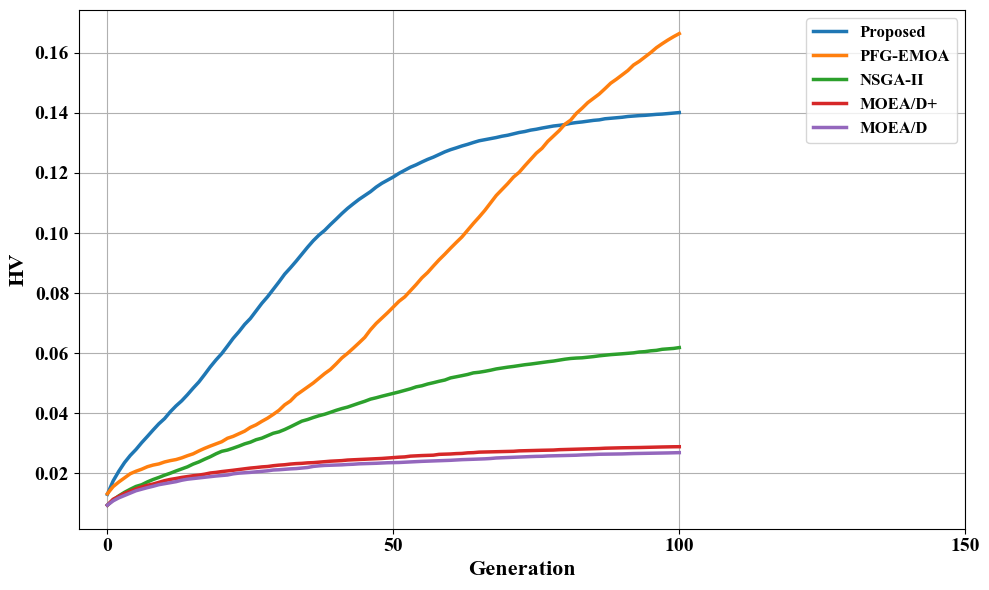

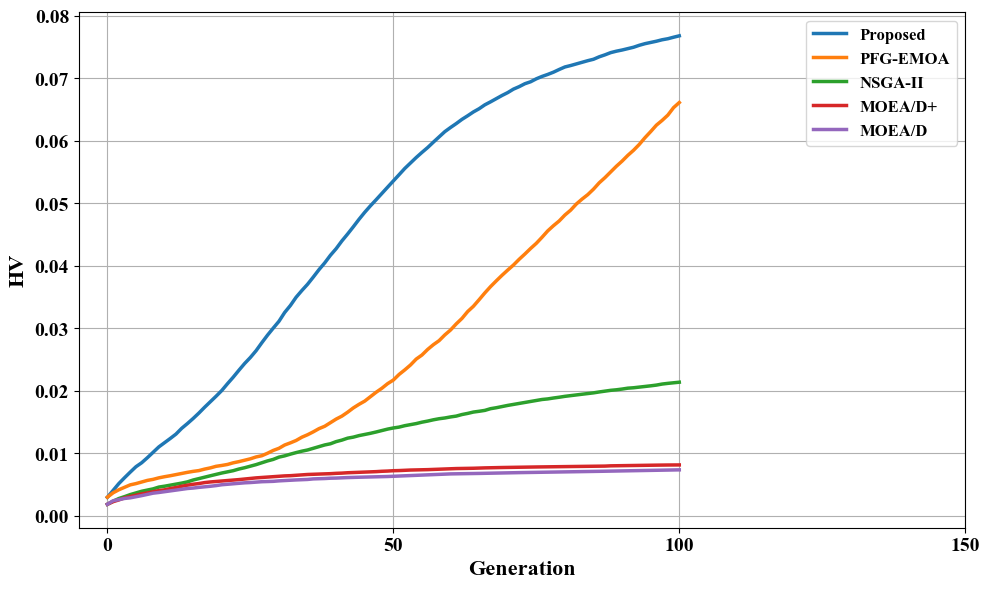

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Set the global font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Settings
# Specify the problem type you want to plot, e.g., 200, 400, or 800

    
for problem_type in[200,400,800]:
    csv_filename = os.path.join(base_path, f"Avg_HV_Trends_Type_{problem_type//100}.csv")

    # Read the CSV file into a DataFrame
    df_avg_hv = pd.read_csv(csv_filename, index_col='Generation')

    # Plot settings
    plt.figure(figsize=(10, 6))

    # Plot each algorithm's HV trend
    # print(df_avg_hv.columns)
    for algorithm in ['Proposed','PFG-EMOA','NSGA-II', 'MOEA/D+', 'MOEA/D']:
        generations = df_avg_hv.index.values
        hv_values = df_avg_hv[algorithm].values
        plt.plot(generations, hv_values, label=algorithm, linewidth=2.5)


    # plt.title(f'Average HV Convergence Trend for {problem_type//2} requests problems', fontsize=14, fontweight='bold')
    plt.xlabel('Generation', fontsize=16, fontweight='bold')
    plt.ylabel('HV', fontsize=16, fontweight='bold')
    plt.grid(True)

    # Restrict x-axis ticks to only 0, 50, 100, 150
    plt.xticks([0, 50, 100, 150], fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')

    # Reverse legend order and set properties: bold text with fontsize 12
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(prop={'weight': 'bold', 'size': 12})

    pdf_filename = os.path.join(base_path, f"HV_Convergence_{problem_type}.pdf")
    plt.savefig(pdf_filename, format='pdf')

    plt.tight_layout()
    plt.show()


In [7]:
import os
import json
import glob
import pandas as pd
import numpy as np
from pymoo.indicators.igd import IGD

def cal_igd(front, ref_pareto):
    """
    Tính toán IGD giữa tập nghiệm front và front tham chiếu ref_pareto.
    """
    igd_indicator = IGD(ref_pareto)
    return igd_indicator(front)

# Settings
base_path = "F:/setup files/downloads/Result2/"
nadir_csv_path = os.path.join(base_path, "nadir_points.csv")

# Load the nadir points CSV
nadir_df = pd.read_csv(nadir_csv_path)

# Define generation range from 0 to 150
generation_steps = range(0, 151)  # 0 to 150

# Chọn các loại vấn đề cần xử lý
problem_types = [200, 400, 800]

for prob_type in problem_types:
    file_pattern = os.path.join(base_path, f"*_{prob_type//100}_*_0.json")
    files = glob.glob(file_pattern)
    
    if not files:
        print(f"No files found for problem type {prob_type}.")
        continue

    # Dictionary to store IGD trends: {algorithm: {generation: [IGD values across files]}}
    igd_trends = {}

    for file_path in files:
        file_name = os.path.basename(file_path)

        # Lấy thông tin nadir tương ứng với file
        nadir_row = nadir_df[nadir_df['file'] == file_name]
        if nadir_row.empty:
            print(f"Nadir info not found for {file_name}. Skipping.")
            continue
        nadir_row = nadir_row.iloc[0]

        # Lấy các cột objective của nadir để tạo front tham chiếu đơn giản
        obj_columns = sorted(
            [col for col in nadir_df.columns if col.startswith("obj_") and col.endswith("_nadir")],
            key=lambda x: int(x.split('_')[1])
        )
        ref_pareto = np.array([nadir_row[col] for col in obj_columns]).reshape(1, -1)

        # Load dữ liệu JSON từ file
        with open(file_path, 'r') as f:
            data = json.load(f)

        # Lặp qua từng thuật toán trong dữ liệu JSON
        for algorithm in data:
            if algorithm not in igd_trends:
                igd_trends[algorithm] = {gen: [] for gen in generation_steps}

            for gen in generation_steps:
                gen_key = str(gen)
                if gen_key not in data[algorithm]:
                    continue

                solutions = data[algorithm][gen_key]
                solutions_np = np.array(solutions)

                if solutions_np.size == 0:
                    continue

                try:
                    igd_value = cal_igd(solutions_np, ref_pareto)
                except Exception as e:
                    print(f"Error computing IGD for {algorithm} at generation {gen} in {file_name}: {e}")
                    continue

                igd_trends[algorithm][gen].append(igd_value)

    # Tính IGD trung bình cho mỗi thế hệ của từng thuật toán
    avg_igd_trends = {}
    for algorithm, gen_dict in igd_trends.items():
        avg_igd_trends[algorithm] = {
            gen: np.mean(igd_list) if igd_list else np.nan 
            for gen, igd_list in gen_dict.items()
        }

    # Lưu kết quả trung bình IGD vào CSV
    df_avg_igd = pd.DataFrame(avg_igd_trends)
    csv_filename = os.path.join(base_path, f"Avg_IGD_Trends_Type_{prob_type//100}.csv")
    df_avg_igd.to_csv(csv_filename, index_label='Generation')
    print(f"Average IGD trends saved to {csv_filename}")

    # Nếu muốn xử lý chỉ một loại vấn đề, bỏ comment break
    # break

Average IGD trends saved to F:/setup files/downloads/Result2/Avg_IGD_Trends_Type_2.csv
Average IGD trends saved to F:/setup files/downloads/Result2/Avg_IGD_Trends_Type_4.csv
Average IGD trends saved to F:/setup files/downloads/Result2/Avg_IGD_Trends_Type_8.csv


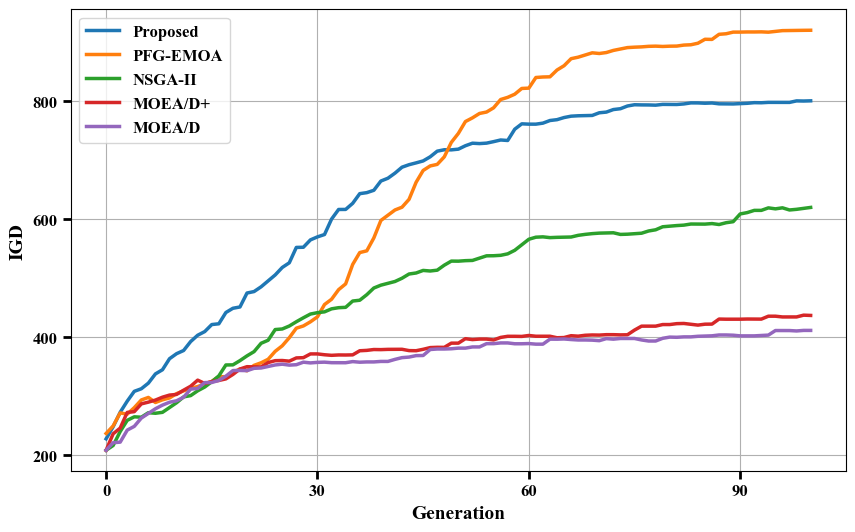

IGD convergence plot saved to F:/setup files/downloads/Result2/IGD_Convergence_Type_2.pdf


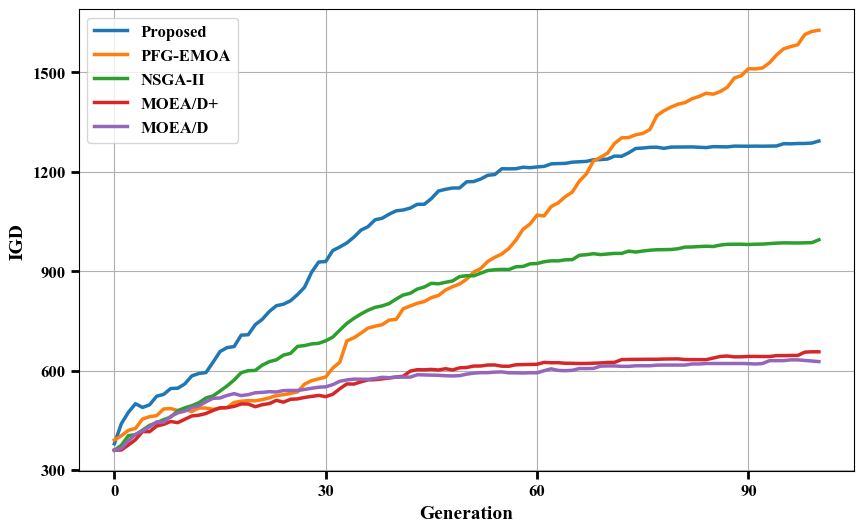

IGD convergence plot saved to F:/setup files/downloads/Result2/IGD_Convergence_Type_4.pdf


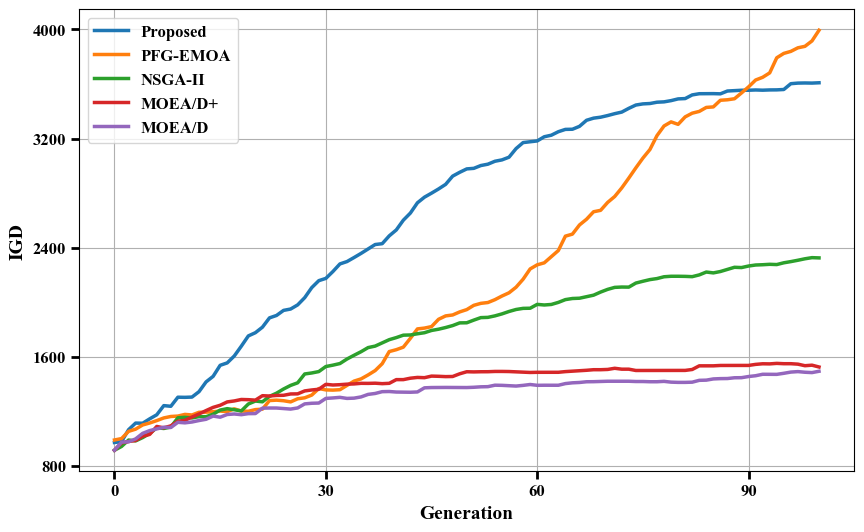

IGD convergence plot saved to F:/setup files/downloads/Result2/IGD_Convergence_Type_8.pdf


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Đặt phông chữ Times New Roman cho toàn bộ plot
plt.rcParams["font.family"] = "Times New Roman"

# Settings
problem_types = [200, 400, 800]

for prob_type in problem_types:
    csv_filename = os.path.join(base_path, f"Avg_IGD_Trends_Type_{prob_type//100}.csv")
    
    # Kiểm tra file CSV có tồn tại không
    if not os.path.exists(csv_filename):
        print(f"CSV file {csv_filename} not found. Skipping.")
        continue

    # Đọc file CSV
    df_avg_igd = pd.read_csv(csv_filename, index_col='Generation')

    # Vẽ đồ thị hội tụ IGD cho từng thuật toán
    plt.figure(figsize=(10, 6))
    for algorithm in ['Proposed','PFG-EMOA','NSGA-II', 'MOEA/D+', 'MOEA/D']:
        gens = df_avg_igd.index
        values = df_avg_igd[algorithm]
        # Vẽ đường với độ dày lớn hơn để làm cho nó đậm hơn
        plt.plot(gens, values, label=algorithm, linewidth=2.5)

    # Thiết lập tiêu đề và nhãn với phông chữ Times New Roman, đậm và kích thước lớn hơn
    title_font = {"fontname": "Times New Roman", "fontsize": 16, "fontweight": "bold"}
    label_font = {"fontname": "Times New Roman", "fontsize": 14, "fontweight": "bold"}
    legend_font = {"family": "Times New Roman", "size": 12, "weight": "bold"}

    plt.xlabel("Generation", **label_font)
    plt.ylabel("IGD", **label_font)

    # Tùy chỉnh legend để sử dụng phông chữ Times New Roman, đậm
    plt.legend(prop=legend_font)

    # Tạo lưới
    plt.grid(True)

    # Tùy chỉnh trục để làm thưa các ticks và in đậm chúng
    ax = plt.gca()

    # Thiết lập locator cho trục X và Y để giảm số lượng ticks
    ax.xaxis.set_major_locator(MaxNLocator(nbins=4))  # Giới hạn số ticks trên trục X
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Giới hạn số ticks trên trục Y

    # Tùy chỉnh giao diện ticks: độ đậm và kích thước
    ax.tick_params(axis='both', which='major', labelsize=12, width=2, length=6)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    # Lưu file PDF
    plot_filename = os.path.join(base_path, f"IGD_Convergence_Type_{prob_type//100}.pdf")
    plt.savefig(plot_filename, format='pdf')
    plt.show()
    plt.close()
    print(f"IGD convergence plot saved to {plot_filename}")